In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import collections
import os
import shutil
import datetime
import keras_tuner as kt
import visualkeras
import pandas as pd 

from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
dataset_directory = "dataset_livrable_1/"

In [ ]:
# def is_image(filename):
#     try:
#         with Image.open(filename) as img:
#             img.verify()
#         return True
#     except (UnidentifiedImageError, OSError):
#         return False

# def move_non_images(directory):
#     dump_directory = "dump"
#     os.makedirs(dump_directory, exist_ok = True)
    
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(folder, file)
#             if not is_image(file_path):
#                 print(f"Déplacement de {file_path} dans le dossier dump/")
#                 dest_path = os.path.join(dump_directory, file)
#                 try:
#                     shutil.move(file_path, dest_path)
#                 except:
#                     print("Erreur lors du déplacement")
                
# move_non_images(dataset_directory)

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
image_h = 128
image_w = 128
batch_s = 16

train_set, test_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.3,
    subset = "both"
)

In [ ]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
validation_size = int(0.5 * len(test_set))

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_set = test_set.take(validation_size).cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.skip(validation_size).cache().prefetch(buffer_size = AUTOTUNE)
num_classes = len(class_names)

In [ ]:
def print_class_distribution(dataset, name):
    label_counts = collections.Counter(label.numpy() for _, label in dataset.unbatch())

    classes = {0: "peintures", 1: "photos", 2: "schémas", 3: "croquis", 4: "textes scannés"}

    total = sum(label_counts.values())
  
    labels = []
    counts = []
    percentages = []

    for label_id in sorted(label_counts):
        class_name = classes.get(label_id, f"Classe inconnue ({label_id})")
        count = label_counts[label_id]
        labels.append(class_name)
        counts.append(count)
        percentages.append(count / total * 100)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)

    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{pct:.1f}%", ha='center', va='bottom')

    plt.title(f"Répartition des classes ({name}_set - {total} images)")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
# print_class_distribution(train_set, "train")
# print_class_distribution(test_set, "test")
# print_class_distribution(validation_set, "validation")

In [ ]:
def ModelTest(*args, **kwargs):
    activation = 'relu'
    model = Sequential(*args, **kwargs)
    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = activation))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = activation))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    model.summary()
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
def ModelTest2(*args,**kwargs):
    activation = 'relu'
    model = Sequential(*args, **kwargs)
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.ZeroPadding2D(padding = (1, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(layers.ZeroPadding2D(padding = (1, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = activation))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    return model  

In [ ]:
modeltest = ModelTest2()
modeltest.summary()
modeltest.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
callbacks = []
tensorboard_callback = TensorBoard(
    log_dir = log_dir,
    histogram_freq = 1
)
checkpoint_callback = ModelCheckpoint(
    filepath = 'checkpoints/best_model_acc.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    verbose = 1
)
checkpoint_callback_2 = ModelCheckpoint(
    filepath = 'checkpoints/best_model_loss.keras',
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = False,
    mode = 'min',
    verbose = 1
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    mode = 'max',
    restore_best_weights = True
)

callbacks.append(early_stopping)
callbacks.append(tensorboard_callback)
callbacks.append(checkpoint_callback)
callbacks.append(checkpoint_callback_2)

In [ ]:
y_train = np.array([label.numpy() for _, label in train_set.unbatch()])
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
def train_model(model, train_set = train_set, test_set = test_set, weights = weights_dict, epochs = 10):

    history = model.fit(
        train_set,
        validation_data = test_set,
        epochs = epochs,
        callbacks = callbacks,
        class_weight = weights
    )
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    epochs_range = range(len(accuracy))
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title("Training and Validation Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss")
    
    plt.show()

In [ ]:
train_model(modeltest, epochs = 30)
modeltest.save('model.keras')


In [20]:
# modeltest.summary()
model = load_model('../models/modelTest2/best_model_loss.keras')

In [21]:

X_test = []
y_true = []

for images, labels in validation_set:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)
def display_matrix(model, X_test = X_test, y_true = y_true, class_names = class_names):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis = 1)
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels = class_names)
    display.plot(cmap = plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.xticks(rotation = 45)
    plt.show()

194/194 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step


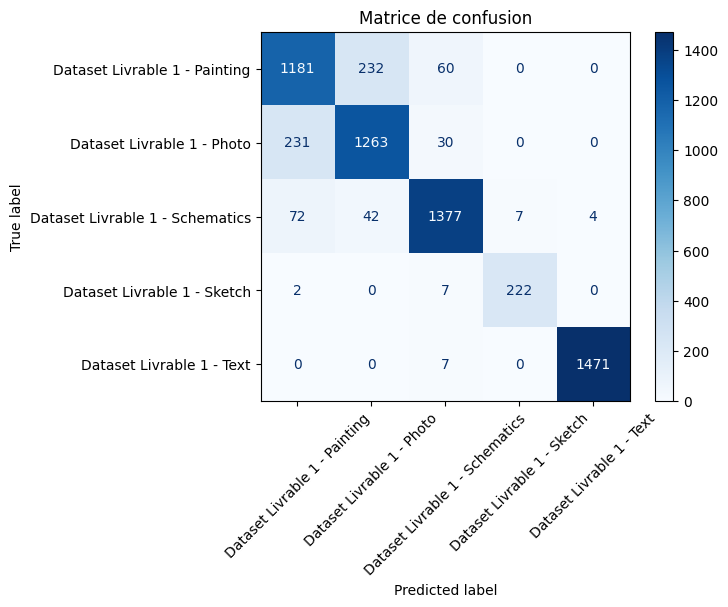

c:\Users\Lucien\Projects\data-science\.venv\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


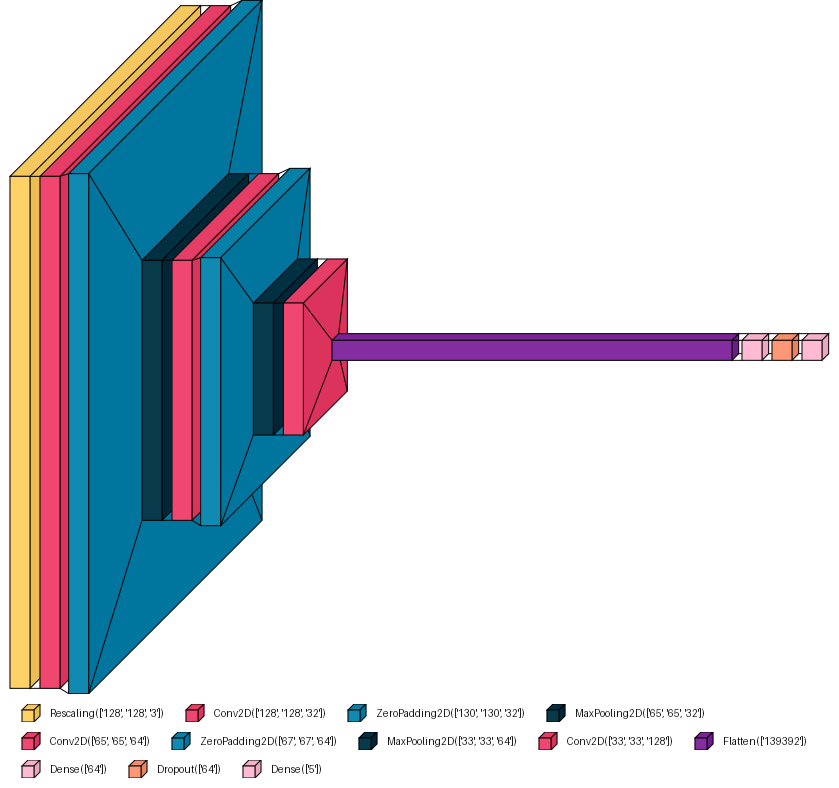

In [22]:
display_matrix(model, X_test, y_true, class_names)
visualkeras.layered_view(
    model,
    legend = True,
    show_dimension = True,
)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 130, 130, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 65, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 67, 67, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 139392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,921,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,044,177 (103.17 MB)

 Trainable params: 9,014,725 (34.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,029,452 (68.78 MB)

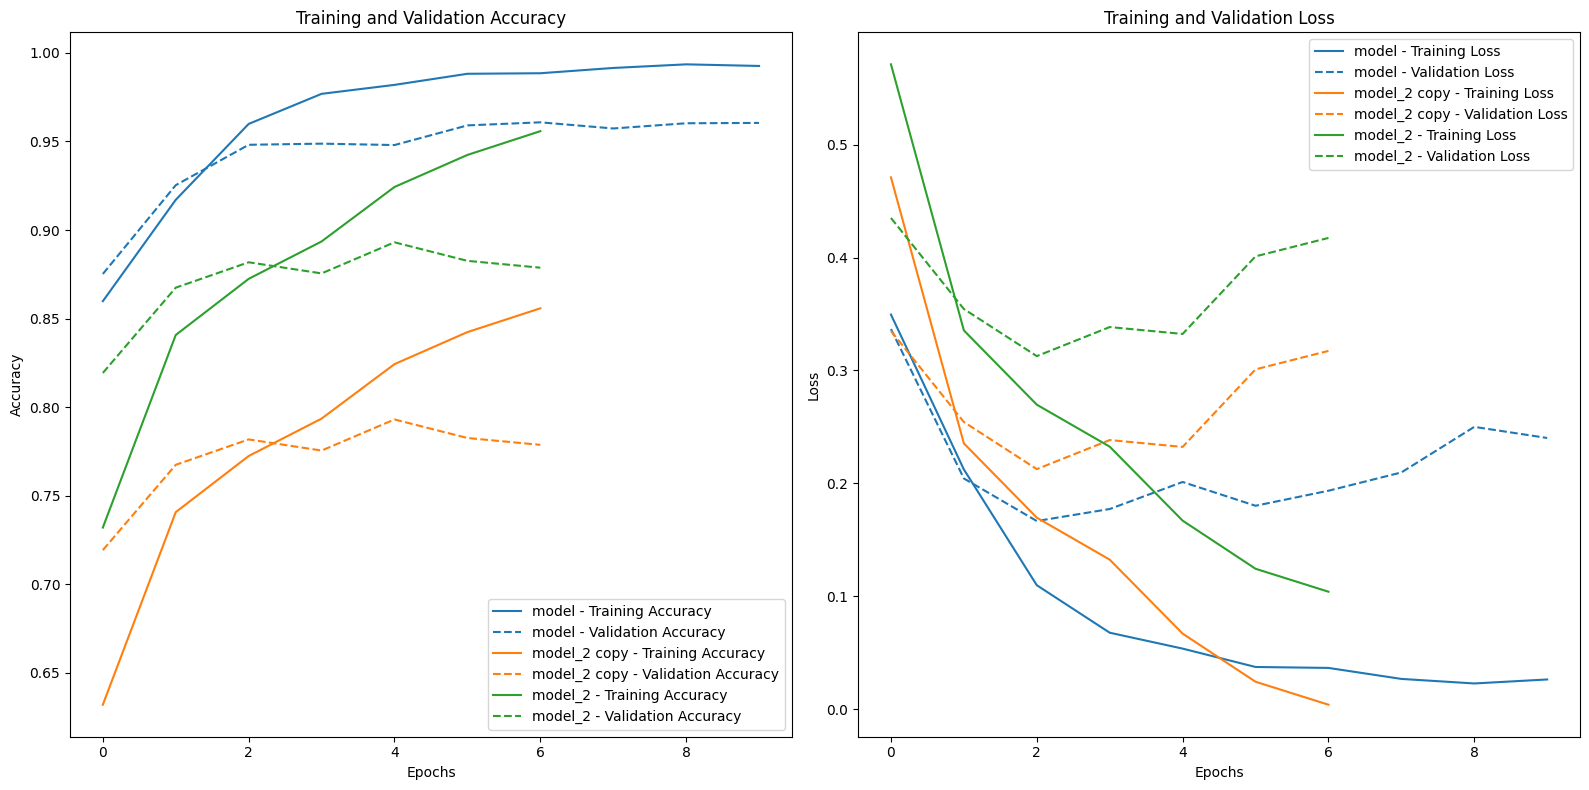

In [35]:
import matplotlib.pyplot as plt
import os
import pandas as pd

# Folder containing the CSV files
folder = "results_csv"

# Initialize lists to store data for plotting
model_names = []
dataframes = []

# Iterate through CSV files in the folder
for file in os.listdir(folder):
  if file.endswith(".csv"):
    # Extract model name (file name without extension)
    model_name = os.path.splitext(file)[0]
    model_names.append(model_name)
    
    # Read the CSV file
    df = pd.read_csv(os.path.join(folder, file), index_col=0)
    dataframes.append((model_name, df))

# Generate a color map for models
colors = plt.cm.tab10(range(len(model_names)))

# Plot accuracy and loss
plt.figure(figsize=(16, 8))

# Subplot for accuracy
plt.subplot(1, 2, 1)
for (model_name, df), color in zip(dataframes, colors):
  plt.plot(df['accuracy'], label=f'{model_name} - Training Accuracy', color=color)
  plt.plot(df['val_accuracy'], linestyle='--', label=f'{model_name} - Validation Accuracy', color=color)
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Subplot for loss
plt.subplot(1, 2, 2)
for (model_name, df), color in zip(dataframes, colors):
  plt.plot(df['loss'], label=f'{model_name} - Training Loss', color=color)
  plt.plot(df['val_loss'], linestyle='--', label=f'{model_name} - Validation Loss', color=color)
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Show the plots
plt.tight_layout()
plt.show()
